# Model Selection

## Objective - To predict divorce with the best model

In [1]:
# Importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix , classification_report, f1_score,\
                            accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

SEED = 0

### Step 1: Load in the required data

In [2]:
df = pd.read_csv("divorce.csv")
df.head(10)

,Atr1,Atr2,Atr3,Atr4,Atr5,Atr6,Atr7,Atr8,Atr9,Atr10,...,Atr46,Atr47,Atr48,Atr49,Atr50,Atr51,Atr52,Atr53,Atr54,Class
0,2,2,4,1,0,0,0,0,0,0,...,2,1,3,3,3,2,3,2,1,1
1,4,4,4,4,4,0,0,4,4,4,...,2,2,3,4,4,4,4,2,2,1
2,2,2,2,2,1,3,2,1,1,2,...,3,2,3,1,1,1,2,2,2,1
3,3,2,3,2,3,3,3,3,3,3,...,2,2,3,3,3,3,2,2,2,1
4,2,2,1,1,1,1,0,0,0,0,...,2,1,2,3,2,2,2,1,0,1
5,0,0,1,0,0,2,0,0,0,1,...,2,2,1,2,1,1,1,2,0,1
6,3,3,3,2,1,3,4,3,2,2,...,3,2,3,2,3,3,2,2,2,1
7,2,1,2,2,2,1,0,3,3,2,...,0,1,2,2,2,1,1,1,0,1
8,2,2,1,0,0,4,1,3,3,3,...,1,1,1,1,1,1,1,1,1,1
9,1,1,1,1,1,2,0,2,2,2,...,2,0,2,2,2,2,4,3,3,1


### Step 3: Split the data and train the models

In [3]:
X=df[['Atr15','Atr17','Atr19','Atr26','Atr38','Atr40']]
y=df['Class']

# Split the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = SEED)

#### Feature scaling

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit only to the training data
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

# Now apply the transformations to the data:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Baseline model using Logistic Regression

In [5]:
logreg = LogisticRegression()

In [6]:
# K-fold cross validation using F1-score as scorer
scores = cross_val_score(logreg, 
                         X_train, 
                         y_train, 
                         cv=5, 
                         scoring='f1_macro')
print('F1 scores:', scores)
print('Mean & standard deviation: {:.2} {:.2f}'.format(scores.mean(), np.std(scores)))

F1 scores: [1.         1.         0.95974235 1.         0.96      ]
Mean & standard deviation: 0.98 0.02


#### Model Selection - Train and evaluate multiple models

In [7]:
# Lists to keep track of model metrics
models = []
precision_list = []
recall_list = []
f1_score_list = []
training_acc_list = []
testing_acc_list = []

In [8]:
# Logistic Regression
logreg = LogisticRegression(n_jobs=-1)

In [9]:
%%time
# Hyperparameter tuning using K-fold cross validation
# ... via Grid Search method
param_grid = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
              'C': np.logspace(-2, 2, 5)}

gs_logreg = GridSearchCV(logreg,
                      param_grid, 
                      cv=5,
                      scoring='f1_macro',
                      n_jobs=-1)
gs_logreg.fit(X_train_scaled, y_train)

Wall time: 4.74 s


GridSearchCV(cv=5, estimator=LogisticRegression(n_jobs=-1), n_jobs=-1,
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'penalty': ['l1', 'l2', 'elasticnet', 'none']},
             scoring='f1_macro')

In [10]:
# Best model hyperparameters and score
print(gs_logreg.best_estimator_)
print(gs_logreg.best_params_)
print(gs_logreg.best_score_)

LogisticRegression(C=10.0, n_jobs=-1)
{'C': 10.0, 'penalty': 'l2'}
0.9919484702093397


In [11]:
# Using best estimator found by GridSearchCV
logreg = gs_logreg.best_estimator_
logreg.fit(X_train_scaled, y_train)

LogisticRegression(C=10.0, n_jobs=-1)

In [12]:
y_pred = logreg.predict(X_test_scaled)

In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        22
           1       1.00      0.95      0.98        21

    accuracy                           0.98        43
   macro avg       0.98      0.98      0.98        43
weighted avg       0.98      0.98      0.98        43



In [14]:
models.append('Logistic Regression')
precision_list.append(precision_score(y_test, y_pred, average='macro'))
recall_list.append(recall_score(y_test, y_pred, average='macro'))
f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
training_acc_list.append(accuracy_score(y_train, logreg.predict(X_train_scaled)))
testing_acc_list.append(accuracy_score(y_test, y_pred))

In [15]:
# Random Forest
rf = RandomForestClassifier(random_state=0)

In [16]:
%%time
# Hyperparameter tuning using K-fold cross validation
# ... via Grid Search method
param_grid = {'n_estimators': [100, 200, 300],
              'criterion': ['gini', 'entropy'],
              'max_depth': [5, 10, 25],
              'min_samples_split': [5, 10, 15]}

gs_rf = GridSearchCV(rf,
                    param_grid, 
                    cv=5,
                    scoring='f1_macro',
                    n_jobs=-1)
gs_rf.fit(X_train_scaled, y_train)

Wall time: 40.6 s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 25],
                         'min_samples_split': [5, 10, 15],
                         'n_estimators': [100, 200, 300]},
             scoring='f1_macro')

In [17]:
# Best model hyperparameters and score
print(gs_rf.best_estimator_)
print(gs_rf.best_params_)
print(gs_rf.best_score_)

RandomForestClassifier(max_depth=5, min_samples_split=5, random_state=0)
{'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
0.9684722797331494


In [18]:
# Using best estimator found by GridSearchCV
rf = gs_rf.best_estimator_
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=5, min_samples_split=5, random_state=0)

In [19]:
y_pred = rf.predict(X_test_scaled)

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        22
           1       1.00      0.95      0.98        21

    accuracy                           0.98        43
   macro avg       0.98      0.98      0.98        43
weighted avg       0.98      0.98      0.98        43



In [21]:
models.append('Random Forest')
precision_list.append(precision_score(y_test, y_pred, average='macro'))
recall_list.append(recall_score(y_test, y_pred, average='macro'))
f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
training_acc_list.append(accuracy_score(y_train, rf.predict(X_train_scaled)))
testing_acc_list.append(accuracy_score(y_test, y_pred))

In [22]:
# Multi-Level Perceptron (stochastic iterative)
mlp = MLPClassifier(solver='sgd')

In [23]:
%%time
# Hyperparameter tuning using K-fold cross validation
# ... via Grid Search method
param_grid = {'hidden_layer_sizes': [(3,3),
                                     (2),
                                     (3)], 
              'alpha': np.logspace(-4, -1, 4),
              'max_iter': [400, 450, 500, 550]}

gs_mlp = GridSearchCV(mlp,
                      param_grid, 
                      cv=5,
                      scoring='f1_macro',
                      n_jobs=-1)
gs_mlp.fit(X_train_scaled, y_train)

Wall time: 26.4 s


GridSearchCV(cv=5, estimator=MLPClassifier(solver='sgd'), n_jobs=-1,
             param_grid={'alpha': array([0.0001, 0.001 , 0.01  , 0.1   ]),
                         'hidden_layer_sizes': [(3, 3), 2, 3],
                         'max_iter': [400, 450, 500, 550]},
             scoring='f1_macro')

In [24]:
# Best model hyperparameters and score
print(gs_mlp.best_estimator_)
print(gs_mlp.best_params_)
print(gs_mlp.best_score_)

MLPClassifier(alpha=0.001, hidden_layer_sizes=(3, 3), max_iter=450,
              solver='sgd')
{'alpha': 0.001, 'hidden_layer_sizes': (3, 3), 'max_iter': 450}
0.9919484702093397


In [25]:
# Using best estimator found by GridSearchCV
mlp = gs_mlp.best_estimator_
mlp.fit(X_train_scaled, y_train)

C:\Users\user\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (450) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(alpha=0.001, hidden_layer_sizes=(3, 3), max_iter=450,
              solver='sgd')

In [26]:
y_pred = mlp.predict(X_test_scaled)

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        22
           1       1.00      0.90      0.95        21

    accuracy                           0.95        43
   macro avg       0.96      0.95      0.95        43
weighted avg       0.96      0.95      0.95        43



In [28]:
models.append('Multilevel Perceptron')
precision_list.append(precision_score(y_test, y_pred, average='macro'))
recall_list.append(recall_score(y_test, y_pred, average='macro'))
f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
training_acc_list.append(accuracy_score(y_train, mlp.predict(X_train_scaled)))
testing_acc_list.append(accuracy_score(y_test, y_pred))

In [29]:
model_metrics = pd.DataFrame(zip(models, training_acc_list, testing_acc_list,
                                 precision_list, recall_list, f1_score_list), 
                             columns=['Model', 'Training Acc', 'Testing Acc', 'Precision', 'Recall', 'F1 Score'])

In [30]:
model_metrics.sort_values(by='F1 Score', ascending=False)

,Model,Training Acc,Testing Acc,Precision,Recall,F1 Score
0,Logistic Regression,1.000000,0.976744,0.978261,0.976190,0.976694
1,Random Forest,0.992126,0.976744,0.978261,0.976190,0.976694
2,Multilevel Perceptron,0.984252,0.953488,0.958333,0.952381,0.953261


### Step 4: Predict and Evaluate with the best model

In [31]:
# Prediction by selected model
y_pred = logreg.predict(X_test_scaled)

In [32]:
# Classification Report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        22
           1       1.00      0.95      0.98        21

    accuracy                           0.98        43
   macro avg       0.98      0.98      0.98        43
weighted avg       0.98      0.98      0.98        43



Text(33.0, 0.5, 'Predicted')

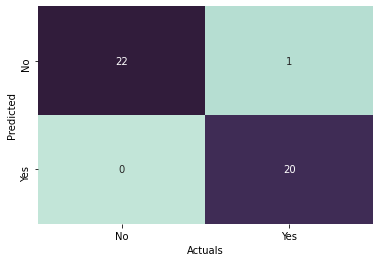

In [33]:
## Confusion Matrix

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat.T, annot=True, fmt='d', cbar=False, cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True),
          xticklabels=['No','Yes'],
          yticklabels=['No','Yes'] )
plt.xlabel('Actuals')
plt.ylabel('Predicted')